In [237]:
import json
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Funciones Auxiliares

In [2]:
def preprocesar(archivos):
  paquetes_tcp = []

  for archivo in archivos:
    with open(archivo) as f:
      paquetes = json.load(f)

      for paquete in paquetes:
        layers = paquete['_source']['layers']
        try:
          if 'tcp' in layers:
            tcp_layer = layers['tcp']
            timestamps = tcp_layer['Timestamps']

            paquete = {
              'tcp.flags.ack': tcp_layer.get('tcp.flags_tree', None).get('tcp.flags.ack', None),
              'tcp.len': tcp_layer.get('tcp.len', None),
              'tcp.seq': tcp_layer.get('tcp.seq', None),
              'tcp.ack': tcp_layer.get('tcp.ack', None),
              'tcp.time_relative': timestamps.get('tcp.time_relative', None),
              'tcp.time_delta': timestamps.get('tcp.time_delta', None)
            }

            paquetes_tcp.append(paquete)
        except KeyError:
          print("Error")
          continue

  df = pd.DataFrame(paquetes_tcp)

  df['tcp.flags.ack'] = pd.to_numeric(df['tcp.flags.ack'], errors='coerce')
  df['tcp.len'] = pd.to_numeric(df['tcp.len'], errors='coerce')
  df['tcp.seq'] = pd.to_numeric(df['tcp.seq'], errors='coerce')
  df['tcp.ack'] = pd.to_numeric(df['tcp.ack'], errors='coerce')
  df['tcp.time_relative'] = pd.to_numeric(df['tcp.time_relative'], errors='coerce')
  df['tcp.time_delta'] = pd.to_numeric(df['tcp.time_delta'], errors='coerce')

  return df

In [61]:
def recortar_dataFrame(df, tiempo_inicio=0, tiempo_final=1000):
  return df.loc[(df['tcp.time_relative'] >= tiempo_inicio) & (df['tcp.time_relative'] <= tiempo_final)].copy()

In [51]:
def calcular_perdida(df, intervalo_tiempo=0.5):
    df['time_window'] = np.floor(df['tcp.time_relative'] / intervalo_tiempo)

    paquetes_enviados_por_ventana = df.groupby('time_window')['tcp.seq'].count()

    paquetes_recibidos_por_ventana = df[df['tcp.flags.ack'] == 1].groupby('time_window')['tcp.ack'].count()

    perdida_por_ventana = paquetes_enviados_por_ventana - paquetes_recibidos_por_ventana.reindex(paquetes_enviados_por_ventana.index, fill_value=0)

    return perdida_por_ventana

In [165]:
def calcular_latencia_ms(df, intervalo_tiempo=0.5):
    df['time_window'] = np.floor(df['tcp.time_relative'] / intervalo_tiempo)
    df['tcp.time_delta_ms'] = df['tcp.time_delta'] * 1000
    latencia_por_ventana = df.groupby("time_window")['tcp.time_delta_ms'].mean()

    return latencia_por_ventana

In [180]:
def calcular_rendimiento_bps(df, intervalo_tiempo=0.5):
    df['time_window'] = np.floor(df['tcp.time_relative'] / intervalo_tiempo)
    df['tcp.len_bits'] = df['tcp.len'] * 8
    throughput_por_ventana = df.groupby('time_window')['tcp.len_bits'].sum()
    throughput_por_ventana /= intervalo_tiempo

    return throughput_por_ventana

## Funciones para combinar los datos de las 2 comunicaciones

In [46]:
def combinar_paquetes_perdidos(df_comunicacion1, df_comunicacion2, intervalo_tiempo=0.5):
  perdidos_comunicacion1 = calcular_perdida(df_comunicacion1, intervalo_tiempo)
  perdidos_comunicacion2 = calcular_perdida(df_comunicacion2, intervalo_tiempo)

  perdida_total = perdidos_comunicacion1.add(perdidos_comunicacion2, fill_value=0)

  return perdida_total

In [128]:
def promediar_metricas(df_comunicacion1, df_comunicacion2, calcular_metrica, intervalo_tiempo=0.5):
  metrica_comunicacion1 = calcular_metrica(df_comunicacion1, intervalo_tiempo=intervalo_tiempo)
  metrica_comunicacion2 = calcular_metrica(df_comunicacion2, intervalo_tiempo=intervalo_tiempo)

  metrica_promedio = (metrica_comunicacion1 + metrica_comunicacion2) / 2

  return metrica_promedio

# Datos

In [ ]:
nombres_algoritmosCongestion = ["Cubic", "Illinois", "YEAH"]
dir_base = "/home/emanuel/Documents/redes/parcial2/Redes_Parcial2/primero/datos/"

In [67]:
dirs = ["cubic-25Mb-4MB/", "illinois-25Mb-4MB/", "yeah-25Mb-4MB/"]
data_frames25Mb_4MB = []

for d in dirs:
  comunicacion1 = preprocesar([dir_base + d + "hub-node0.json"])
  comunicacion2 = preprocesar([dir_base + d + "hub-node1.json"])

  data_frames25Mb_4MB.append((comunicacion1, comunicacion2))

In [33]:
dirs = ["cubic-50Mb-7MB/", "illinois-50Mb-7MB/", "yeah-50Mb-7MB/"]
data_frames50Mb_7MB = []

for d in dirs:
  comunicacion1 = preprocesar([dir_base + d + "hub-node0.json"])
  comunicacion2 = preprocesar([dir_base + d + "hub-node1.json"])

  data_frames50Mb_7MB.append((comunicacion1, comunicacion2))

In [32]:
dirs = ["cubic-100Mb-18MB/", "illinois-100Mb-18MB/", "yeah-100Mb-18MB/"]
data_frames100Mb_18MB = []

for d in dirs:
  comunicacion1 = preprocesar([dir_base + d + "hub-node0.json"])
  comunicacion2 = preprocesar([dir_base + d + "hub-node1.json"])

  data_frames100Mb_18MB.append((comunicacion1, comunicacion2))

# Gráficas

## Funciones para graficar las tres métricas

In [239]:
def graficarMetrica(data_frames_combinados, intervalo_tiempo=0.5):
  f, ax = plt.subplots(figsize=(10, 5))

  for i, df in enumerate(data_frames_combinados):
    ax.plot(df.index * intervalo_tiempo, df.values, label=nombres_algoritmosCongestion[i])

  return ax

In [149]:
def graficarPerdidaPaquetes(data_frames_combinados):
  ax = graficarMetrica(data_frames_combinados)

  ax.set_title("Evolución de la Pérdida de Paquetes en el Tiempo")
  ax.set_xlabel("Tiempo (s)")
  ax.set_ylabel("Pérdida de paquetes")
  ax.grid(True)
  ax.legend()

  return ax

In [158]:
def graficarLatencia(data_frames_combinados):
  ax = graficarMetrica(data_frames_combinados)

  ax.set_title("Evolución de la Latencia en el Tiempo")
  ax.set_xlabel("Tiempo (s)")
  ax.set_ylabel("Latencia (ms)")
  ax.grid(True)
  ax.legend()

  return ax

In [183]:
def graficarRendimiento(data_frames_combinados):
  ax = graficarMetrica(data_frames_combinados)

  ax.set_title("Evolución del Rendimiento en el Tiempo")
  ax.set_xlabel("Tiempo (s)")
  ax.set_ylabel("Rendimiento (bps)")
  ax.grid(True)
  ax.legend()

  return ax

## Simulación con ancho de banda de 25Mbps y 4MB de tráfico por comunicación

### Paquetes perdidos

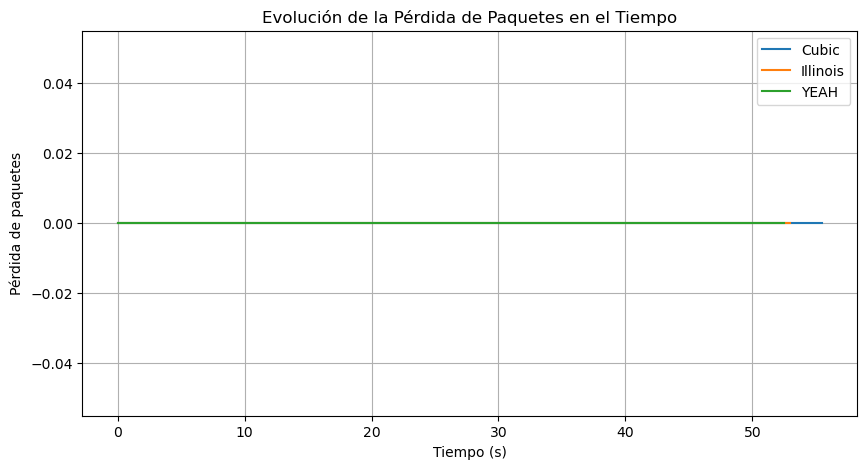

In [240]:
data_frames = []
for df in data_frames25Mb_4MB:
  df_filtrado0 = recortar_dataFrame(df[0], tiempo_inicio=0.008)
  df_filtrado1 = recortar_dataFrame(df[1], tiempo_inicio=0.008)
  df_combinado = combinar_paquetes_perdidos(df_filtrado0, df_filtrado1)
  data_frames.append(df_combinado)

ax = graficarPerdidaPaquetes(data_frames)
plt.show()

### Latencia

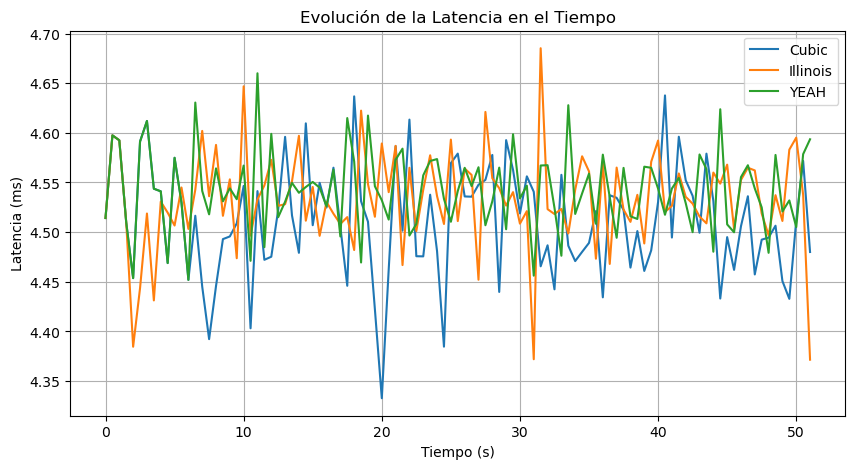

In [241]:
data_frames = []
for df in data_frames25Mb_4MB:
  df_filtrado0 = recortar_dataFrame(df[0], tiempo_final=51.1)
  df_filtrado1 = recortar_dataFrame(df[1], tiempo_final=51.1)
  df_combinado = promediar_metricas(df_filtrado0, df_filtrado1, calcular_latencia_ms)
  data_frames.append(df_combinado)

ax = graficarLatencia(data_frames)
plt.show()

### Rendimiento

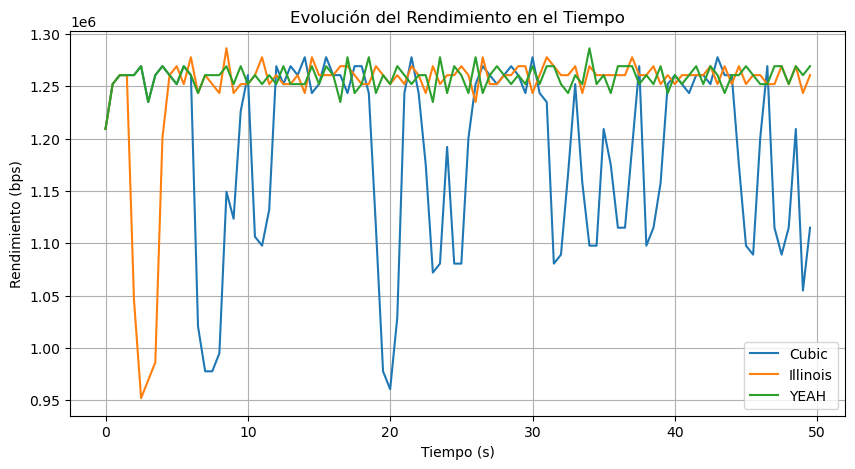

In [242]:
data_frames = []
for df in data_frames25Mb_4MB:
  df_filtrado0 = recortar_dataFrame(df[0], tiempo_final=50.0008)
  df_filtrado1 = recortar_dataFrame(df[1], tiempo_final=50.0008)
  df_combinado = promediar_metricas(df_filtrado0, df_filtrado1, calcular_rendimiento_bps)
  data_frames.append(df_combinado)

ax = graficarRendimiento(data_frames)
plt.show()

## Simulación con ancho de banda de 50Mbps y 7MB de tráfico por comunicación

### Paquetes perdidos

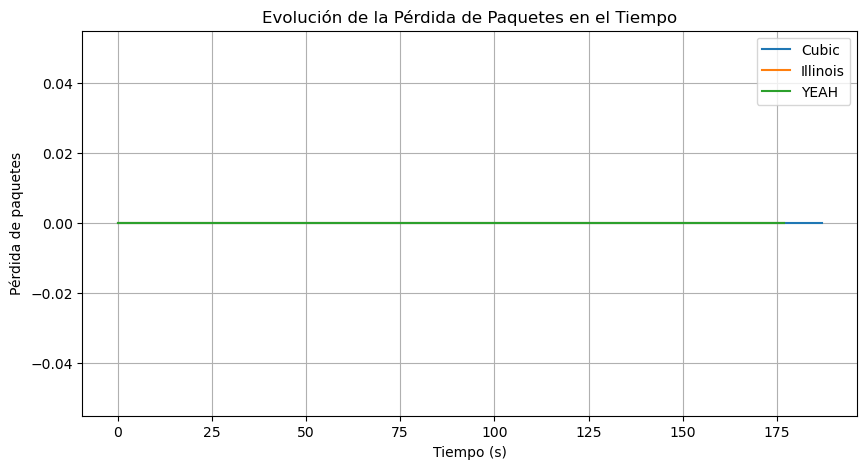

In [193]:
data_frames = []
for df in data_frames50Mb_7MB:
  df_filtrado0 = recortar_dataFrame(df[0], tiempo_inicio=0.008)
  df_filtrado1 = recortar_dataFrame(df[1], tiempo_inicio=0.008)
  df_combinado = combinar_paquetes_perdidos(df_filtrado0, df_filtrado1)
  data_frames.append(df_combinado)

ax = graficarPerdidaPaquetes(data_frames)
plt.show()

### Latencia

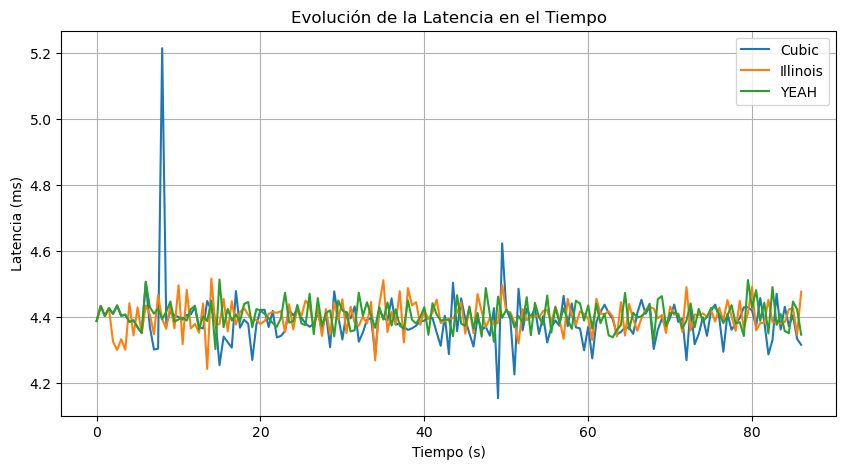

In [243]:
data_frames = []
for df in data_frames50Mb_7MB:
  df_filtrado0 = recortar_dataFrame(df[0], tiempo_final=86.5)
  df_filtrado1 = recortar_dataFrame(df[1], tiempo_final=86.5)
  df_combinado = promediar_metricas(df_filtrado0, df_filtrado1, calcular_latencia_ms)
  data_frames.append(df_combinado)

ax = graficarLatencia(data_frames)
plt.show()

### Rendimiento

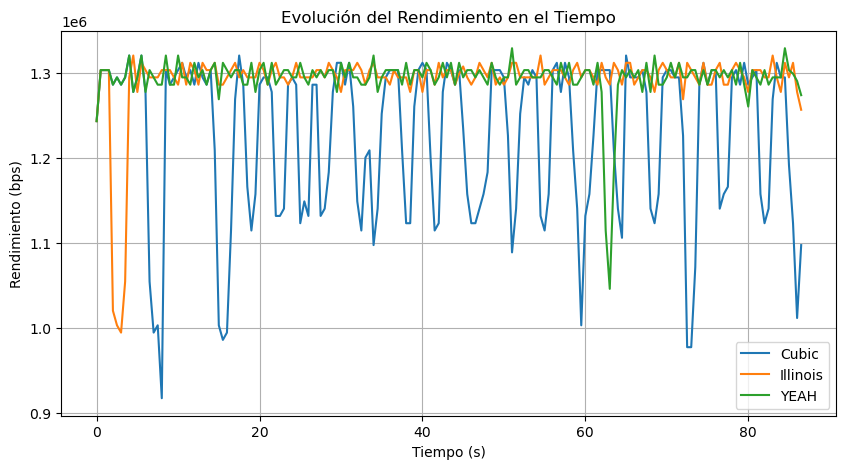

In [244]:
data_frames = []
for df in data_frames50Mb_7MB:
  df_filtrado0 = recortar_dataFrame(df[0], tiempo_final=87)
  df_filtrado1 = recortar_dataFrame(df[1], tiempo_final=87)
  df_combinado = promediar_metricas(df_filtrado0, df_filtrado1, calcular_rendimiento_bps)
  data_frames.append(df_combinado)

ax = graficarRendimiento(data_frames)
plt.show()

## Simulación con ancho de banda de 100Mbps y 18MB de tráfico por comunicación

### Paquetes perdidos

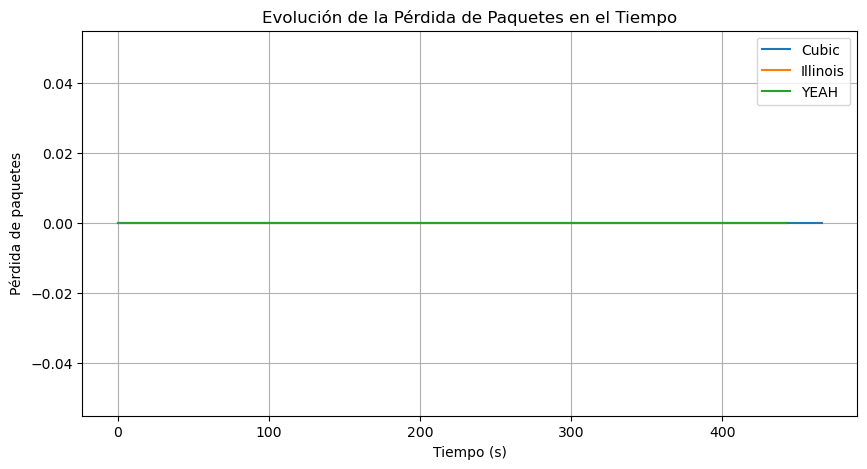

In [192]:
data_frames = []
for df in data_frames100Mb_18MB:
  df_filtrado0 = recortar_dataFrame(df[0], tiempo_inicio=0.008)
  df_filtrado1 = recortar_dataFrame(df[1], tiempo_inicio=0.008)
  df_combinado = combinar_paquetes_perdidos(df_filtrado0, df_filtrado1)
  data_frames.append(df_combinado)

ax = graficarPerdidaPaquetes(data_frames)
plt.show()

### Latencia

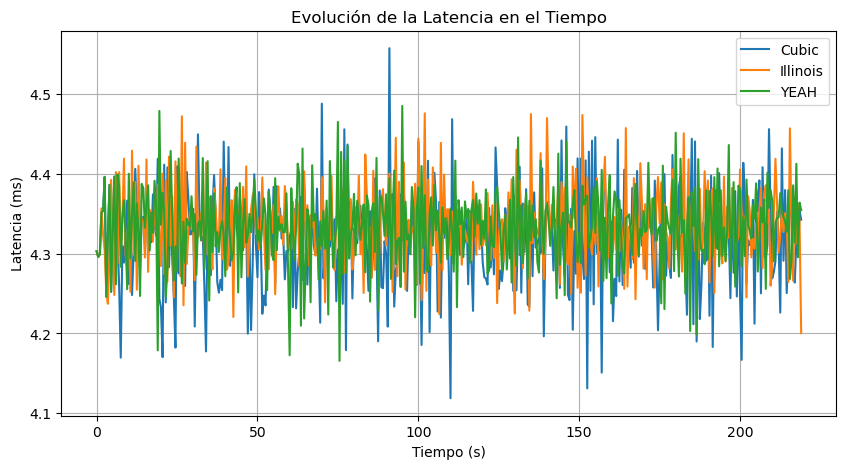

In [245]:
data_frames = []
for df in data_frames100Mb_18MB:
  df_filtrado0 = recortar_dataFrame(df[0], tiempo_final=219.45)
  df_filtrado1 = recortar_dataFrame(df[1], tiempo_final=219.45)
  df_combinado = promediar_metricas(df_filtrado0, df_filtrado1, calcular_latencia_ms)
  data_frames.append(df_combinado)

ax = graficarLatencia(data_frames)
plt.show()

### Rendimiento

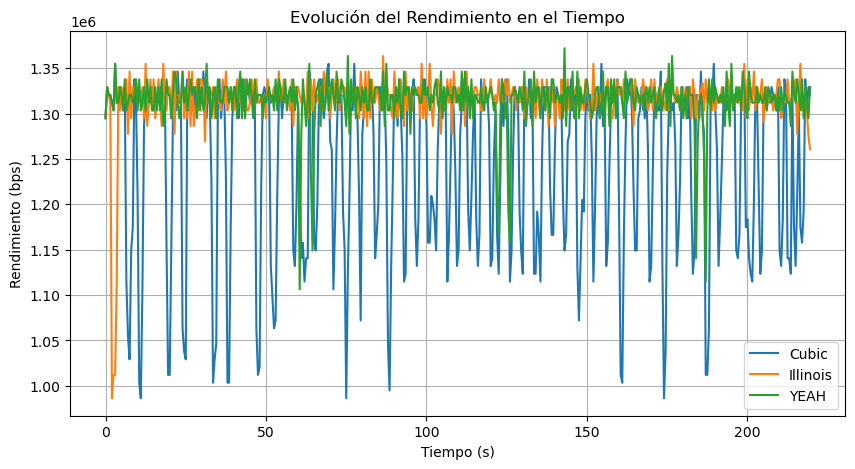

In [246]:
data_frames = []
for df in data_frames100Mb_18MB:
  df_filtrado0 = recortar_dataFrame(df[0], tiempo_final=220)
  df_filtrado1 = recortar_dataFrame(df[1], tiempo_final=220)
  df_combinado = promediar_metricas(df_filtrado0, df_filtrado1, calcular_rendimiento_bps)
  data_frames.append(df_combinado)

ax = graficarRendimiento(data_frames)
plt.show()

# Resumen de las métricas obtenidas

In [216]:
def obtenerEstadisticasSerie(data_frames):
    estadisticas = []

    for df in data_frames:
        estadisticasSerie = {
            "promedio": np.mean(df),
            "desviacion_estandar": np.std(df)
        }

        estadisticas.append(estadisticasSerie)

    return estadisticas

In [226]:
def graficarEstadisticasSerie(estadisticas_serie, titulo, nombre_metrica):
  promedios = [estadisticas["promedio"] for estadisticas in estadisticas_serie]
  desviaciones = [estadisticas["desviacion_estandar"] for estadisticas in estadisticas_serie]

  f, ax = plt.subplots(figsize=(10, 5))
  ax.bar(nombres_algoritmosCongestion, promedios, yerr=desviaciones)
  ax.set_title(titulo)
  ax.set_ylabel(nombre_metrica)
  ax.grid(True)

  return ax

## Latencia

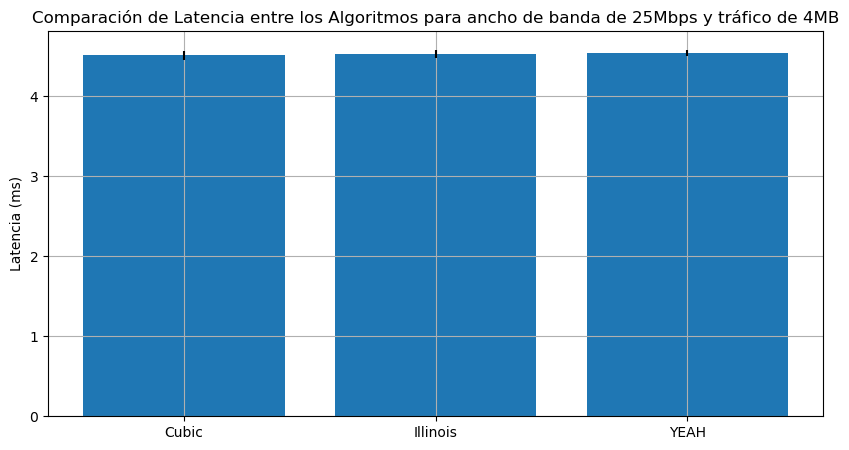

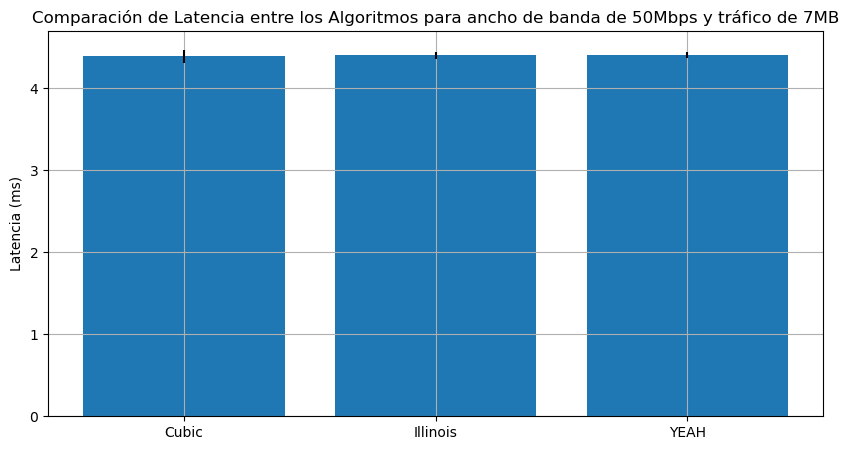

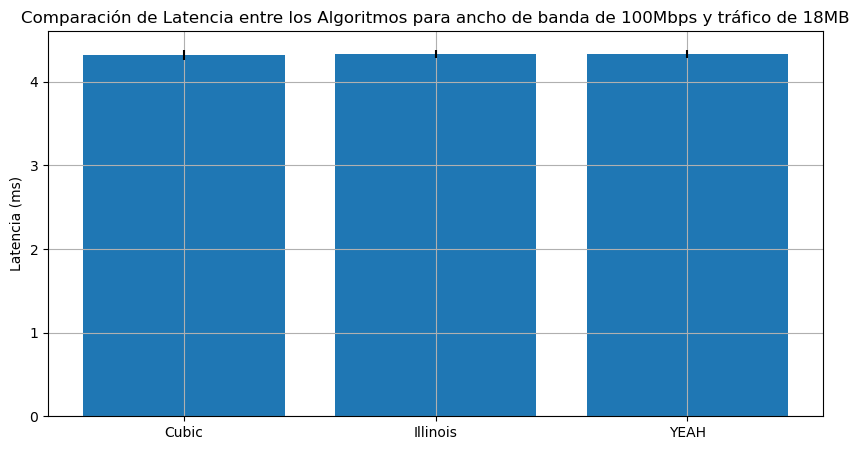

In [234]:
data_frames = []

for df in data_frames25Mb_4MB:
  df_filtrado0 = recortar_dataFrame(df[0], tiempo_final=51.1)
  df_filtrado1 = recortar_dataFrame(df[1], tiempo_final=51.1)
  df_combinado = promediar_metricas(df_filtrado0, df_filtrado1, calcular_latencia_ms)
  data_frames.append(df_combinado)

estadisticasLatencia = obtenerEstadisticasSerie(data_frames)
ax25Mb_4MB = graficarEstadisticasSerie(estadisticasLatencia,
 "Comparación de Latencia entre los Algoritmos para ancho de banda de 25Mbps y tráfico de 4MB", "Latencia (ms)")

data_frames = []
for df in data_frames50Mb_7MB:
  df_filtrado0 = recortar_dataFrame(df[0], tiempo_final=86.5)
  df_filtrado1 = recortar_dataFrame(df[1], tiempo_final=86.5)
  df_combinado = promediar_metricas(df_filtrado0, df_filtrado1, calcular_latencia_ms)
  data_frames.append(df_combinado)

estadisticasLatencia = obtenerEstadisticasSerie(data_frames)
ax50Mb_7MB = graficarEstadisticasSerie(estadisticasLatencia, 
"Comparación de Latencia entre los Algoritmos para ancho de banda de 50Mbps y tráfico de 7MB", "Latencia (ms)")

data_frames = []
for df in data_frames100Mb_18MB:
  df_filtrado0 = recortar_dataFrame(df[0], tiempo_final=219.45)
  df_filtrado1 = recortar_dataFrame(df[1], tiempo_final=219.45)
  df_combinado = promediar_metricas(df_filtrado0, df_filtrado1, calcular_latencia_ms)
  data_frames.append(df_combinado)

estadisticasLatencia = obtenerEstadisticasSerie(data_frames)
ax100Mb_18MB = graficarEstadisticasSerie(estadisticasLatencia,
 "Comparación de Latencia entre los Algoritmos para ancho de banda de 100Mbps y tráfico de 18MB", "Latencia (ms)")

## Rendimiento

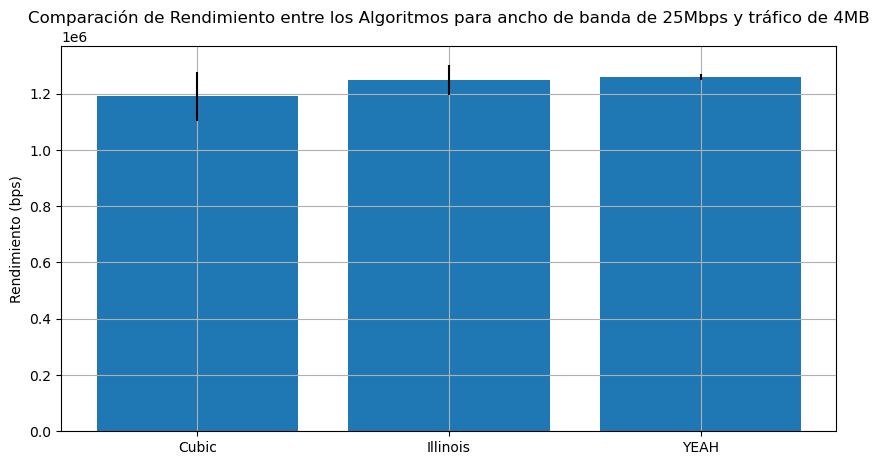

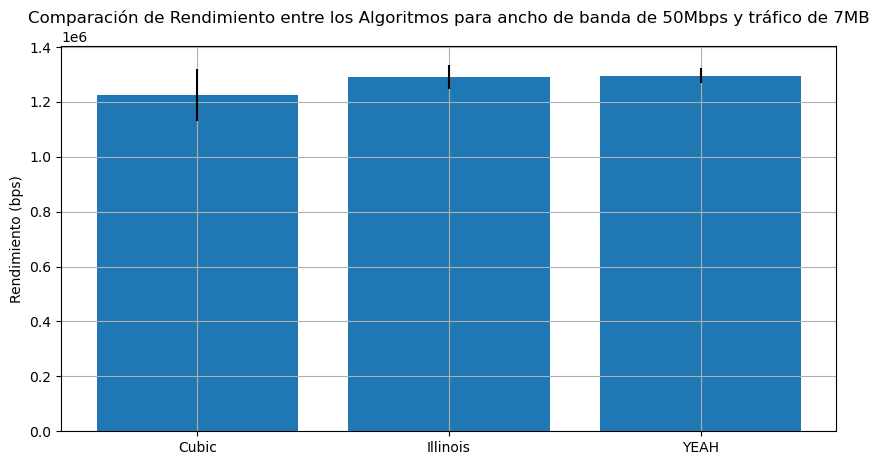

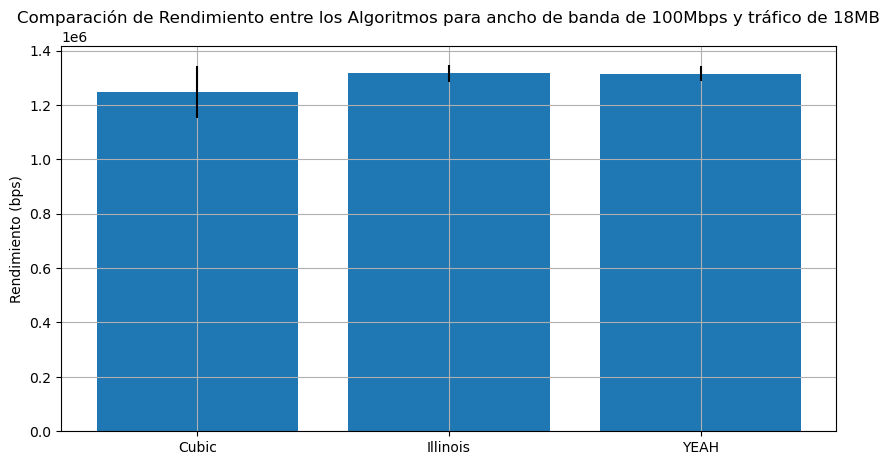

In [236]:
data_frames = []

for df in data_frames25Mb_4MB:
  df_filtrado0 = recortar_dataFrame(df[0], tiempo_final=50.0008)
  df_filtrado1 = recortar_dataFrame(df[1], tiempo_final=50.0008)
  df_combinado = promediar_metricas(df_filtrado0, df_filtrado1, calcular_rendimiento_bps)
  data_frames.append(df_combinado)

estadisticasLatencia = obtenerEstadisticasSerie(data_frames)
ax25Mb_4MB = graficarEstadisticasSerie(estadisticasLatencia,
 "Comparación de Rendimiento entre los Algoritmos para ancho de banda de 25Mbps y tráfico de 4MB", "Rendimiento (bps)")

data_frames = []
for df in data_frames50Mb_7MB:
  df_filtrado0 = recortar_dataFrame(df[0], tiempo_final=87)
  df_filtrado1 = recortar_dataFrame(df[1], tiempo_final=87)
  df_combinado = promediar_metricas(df_filtrado0, df_filtrado1, calcular_rendimiento_bps)
  data_frames.append(df_combinado)

estadisticasLatencia = obtenerEstadisticasSerie(data_frames)
ax50Mb_7MB = graficarEstadisticasSerie(estadisticasLatencia, 
"Comparación de Rendimiento entre los Algoritmos para ancho de banda de 50Mbps y tráfico de 7MB", "Rendimiento (bps)")

data_frames = []
for df in data_frames100Mb_18MB:
  df_filtrado0 = recortar_dataFrame(df[0], tiempo_final=220)
  df_filtrado1 = recortar_dataFrame(df[1], tiempo_final=220)
  df_combinado = promediar_metricas(df_filtrado0, df_filtrado1, calcular_rendimiento_bps)
  data_frames.append(df_combinado)

estadisticasLatencia = obtenerEstadisticasSerie(data_frames)
ax100Mb_18MB = graficarEstadisticasSerie(estadisticasLatencia,
 "Comparación de Rendimiento entre los Algoritmos para ancho de banda de 100Mbps y tráfico de 18MB", "Rendimiento (bps)")